In [17]:
# Navigating to the project directory

%cd /home/teamdaedulus/

/home/teamdaedulus


#### Importing required packages

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

#### Load preprocessed features for training

In [2]:
X_train = torch.from_numpy(np.load("data/X_train.npy")).long()
Y_train = torch.from_numpy(np.load("data/Y_train.npy")).long()
print(f"Training data: X - {X_train.shape}, Y - {Y_train.shape}")

Training data: X - torch.Size([18000, 5000]), Y - torch.Size([18000])


#### Set device to GPU if available

In [21]:
torch.cuda.empty_cache()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

### Define required model and layers

#### Define Attention Layer

In [22]:
# Code inspired from the following blog post
# https://towardsdatascience.com/nlp-learning-series-part-3-attention-cnn-and-what-not-for-text-classification-4313930ed566
class Attention(nn.Module):
    def __init__(self, feature_dim, step_dim, bias=True, **kwargs):
        super(Attention, self).__init__(**kwargs)        
        self.supports_masking = True
        
        self.bias = bias
        self.feature_dim = feature_dim
        self.step_dim = step_dim
        self.features_dim = 0
        
        weight = torch.zeros(feature_dim, 1)
        nn.init.kaiming_uniform_(weight)
        self.weight = nn.Parameter(weight)
        
        if bias:
            self.b = nn.Parameter(torch.zeros(step_dim))
        
    def forward(self, x, mask=None):
        feature_dim = self.feature_dim 
        step_dim = self.step_dim

        eij = torch.mm(
            x.contiguous().view(-1, feature_dim), 
            self.weight
        ).view(-1, step_dim)
        
        if self.bias:
            eij = eij + self.b
            
        eij = torch.tanh(eij)
        a = torch.exp(eij)
        
        if mask is not None:
            a = a * mask

        a = a / (torch.sum(a, 1, keepdim=True) + 1e-10)

        weighted_input = x * torch.unsqueeze(a, -1)
        return torch.sum(weighted_input, 1)

#### Define the deepSRGM model for Raga Classification

In [23]:
class Model(nn.Module):
    def __init__(self, input_length=5000, embedding_size=128, hidden_size=768,
                num_layers=1, num_classes=10, vocab_size=209, drop_prob=0.5):
      super(Model, self).__init__()
      self.num_layers = num_layers
      self.hidden_size = hidden_size
      self.embeddings = nn.Embedding(vocab_size, embedding_size)
    
      self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers,
                          dropout=drop_prob, batch_first=True)
      self.attention_layer = Attention(hidden_size, input_length)
        
      self.fc1 = nn.Linear(hidden_size, 384)
      self.fc2 = nn.Linear(384, num_classes)
    
      # self.batchNorm1d = nn.BatchNorm1d(input_length)
      self.dropout = nn.Dropout(0.3)      
      self.relu = nn.ReLU()

    def forward(self, x):
      batch_size = x.size(0)
      embeds = self.embeddings(x)
      # print("embeds ", embeds.shape)
      h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
      c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
      out, _ = self.lstm(embeds, (h0, c0)) #We don't need the hidden tensor
      # print("lstm ", out.shape)
      # out = self.batchNorm1d(out)
      out = self.attention_layer(out)
      # print("attention ", out.shape)
     
      out = self.relu(self.fc1(out))
      # print("fc1 ", out.shape)
      out = self.dropout(out)
      out = self.fc2(out)
      # print("output ", out.shape)

      return out

### Using model to train for Raga Recognition

In [24]:
model = Model().to(device)

/opt/anaconda3/envs/pipenv/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [8]:
# Model parameters for the 10-raga subset classification

# input_size = 128
# hidden_size = 768
# num_layers = 1
# num_classes = 10

#### Create PyTorch dataset and dataloader to create batches

In [3]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 40
trainset = TensorDataset(X_train, Y_train)
trainloader = DataLoader(trainset, shuffle=True, batch_size=batch_size)

In [4]:
len(trainloader)

450

#### Define Loss criterion and optimizer

In [10]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = Adam(model.parameters(), lr=0.0001)

#### Train the model

In [11]:
# training the model
model.train()
losslist = []
for epoch in range(30):  # loop over the dataset multiple times
    running_loss = 0.0
    epoch_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 15 == 14:    # print every 15 mini-batches
            print(f'Epoch: {epoch+1} | Batches Done: {i+1}/450 | Loss: {(running_loss/15):.3f}')
            epoch_loss += running_loss
            running_loss = 0.0
    losslist.append(epoch_loss/450)
    print("="*50)
    print(f"EPOCH {epoch+1} OVERALL LOSS: {losslist[-1]:.3f}")
    print("="*50)
    if epoch % 5 == 4:
        path = f"models/lstm_{epoch+1}_checkpoint.pth"
        print(f"Saving model weights at Epoch {epoch+1} ...")
        torch.save(model.state_dict(), path)

Epoch: 1 | Batches Done: 15/450 | Loss: 2.299
Epoch: 1 | Batches Done: 30/450 | Loss: 2.289
Epoch: 1 | Batches Done: 45/450 | Loss: 2.277
Epoch: 1 | Batches Done: 60/450 | Loss: 2.233
Epoch: 1 | Batches Done: 75/450 | Loss: 2.158
Epoch: 1 | Batches Done: 90/450 | Loss: 1.970
Epoch: 1 | Batches Done: 105/450 | Loss: 1.794
Epoch: 1 | Batches Done: 120/450 | Loss: 1.780
Epoch: 1 | Batches Done: 135/450 | Loss: 1.688
Epoch: 1 | Batches Done: 150/450 | Loss: 1.634
Epoch: 1 | Batches Done: 165/450 | Loss: 1.584
Epoch: 1 | Batches Done: 180/450 | Loss: 1.552
Epoch: 1 | Batches Done: 195/450 | Loss: 1.525
Epoch: 1 | Batches Done: 210/450 | Loss: 1.536
Epoch: 1 | Batches Done: 225/450 | Loss: 1.390
Epoch: 1 | Batches Done: 240/450 | Loss: 1.397
Epoch: 1 | Batches Done: 255/450 | Loss: 1.373
Epoch: 1 | Batches Done: 270/450 | Loss: 1.317
Epoch: 1 | Batches Done: 285/450 | Loss: 1.334
Epoch: 1 | Batches Done: 300/450 | Loss: 1.325
Epoch: 1 | Batches Done: 315/450 | Loss: 1.234
Epoch: 1 | Batches 

Epoch: 6 | Batches Done: 180/450 | Loss: 0.303
Epoch: 6 | Batches Done: 195/450 | Loss: 0.285
Epoch: 6 | Batches Done: 210/450 | Loss: 0.277
Epoch: 6 | Batches Done: 225/450 | Loss: 0.269
Epoch: 6 | Batches Done: 240/450 | Loss: 0.304
Epoch: 6 | Batches Done: 255/450 | Loss: 0.271
Epoch: 6 | Batches Done: 270/450 | Loss: 0.317
Epoch: 6 | Batches Done: 285/450 | Loss: 0.293
Epoch: 6 | Batches Done: 300/450 | Loss: 0.292
Epoch: 6 | Batches Done: 315/450 | Loss: 0.239
Epoch: 6 | Batches Done: 330/450 | Loss: 0.268
Epoch: 6 | Batches Done: 345/450 | Loss: 0.271
Epoch: 6 | Batches Done: 360/450 | Loss: 0.300
Epoch: 6 | Batches Done: 375/450 | Loss: 0.261
Epoch: 6 | Batches Done: 390/450 | Loss: 0.241
Epoch: 6 | Batches Done: 405/450 | Loss: 0.250
Epoch: 6 | Batches Done: 420/450 | Loss: 0.251
Epoch: 6 | Batches Done: 435/450 | Loss: 0.268
Epoch: 6 | Batches Done: 450/450 | Loss: 0.279
EPOCH 6 OVERALL LOSS: 0.305
Epoch: 7 | Batches Done: 15/450 | Loss: 0.281
Epoch: 7 | Batches Done: 30/450 |

Epoch: 11 | Batches Done: 330/450 | Loss: 0.374
Epoch: 11 | Batches Done: 345/450 | Loss: 0.357
Epoch: 11 | Batches Done: 360/450 | Loss: 0.302
Epoch: 11 | Batches Done: 375/450 | Loss: 0.337
Epoch: 11 | Batches Done: 390/450 | Loss: 0.274
Epoch: 11 | Batches Done: 405/450 | Loss: 0.348
Epoch: 11 | Batches Done: 420/450 | Loss: 0.237
Epoch: 11 | Batches Done: 435/450 | Loss: 0.313
Epoch: 11 | Batches Done: 450/450 | Loss: 0.260
EPOCH 11 OVERALL LOSS: 0.283
Epoch: 12 | Batches Done: 15/450 | Loss: 0.213
Epoch: 12 | Batches Done: 30/450 | Loss: 0.243
Epoch: 12 | Batches Done: 45/450 | Loss: 0.251
Epoch: 12 | Batches Done: 60/450 | Loss: 0.235
Epoch: 12 | Batches Done: 75/450 | Loss: 0.253
Epoch: 12 | Batches Done: 90/450 | Loss: 0.241
Epoch: 12 | Batches Done: 105/450 | Loss: 0.225
Epoch: 12 | Batches Done: 120/450 | Loss: 0.203
Epoch: 12 | Batches Done: 135/450 | Loss: 0.268
Epoch: 12 | Batches Done: 150/450 | Loss: 0.254
Epoch: 12 | Batches Done: 165/450 | Loss: 0.259
Epoch: 12 | Batch

Epoch: 16 | Batches Done: 435/450 | Loss: 0.120
Epoch: 16 | Batches Done: 450/450 | Loss: 0.117
EPOCH 16 OVERALL LOSS: 0.112
Epoch: 17 | Batches Done: 15/450 | Loss: 0.107
Epoch: 17 | Batches Done: 30/450 | Loss: 0.096
Epoch: 17 | Batches Done: 45/450 | Loss: 0.096
Epoch: 17 | Batches Done: 60/450 | Loss: 0.072
Epoch: 17 | Batches Done: 75/450 | Loss: 0.123
Epoch: 17 | Batches Done: 90/450 | Loss: 0.146
Epoch: 17 | Batches Done: 105/450 | Loss: 0.206
Epoch: 17 | Batches Done: 120/450 | Loss: 0.190
Epoch: 17 | Batches Done: 135/450 | Loss: 0.203
Epoch: 17 | Batches Done: 150/450 | Loss: 0.380
Epoch: 17 | Batches Done: 165/450 | Loss: 0.340
Epoch: 17 | Batches Done: 180/450 | Loss: 0.215
Epoch: 17 | Batches Done: 195/450 | Loss: 0.158
Epoch: 17 | Batches Done: 210/450 | Loss: 0.157
Epoch: 17 | Batches Done: 225/450 | Loss: 0.149
Epoch: 17 | Batches Done: 240/450 | Loss: 0.167
Epoch: 17 | Batches Done: 255/450 | Loss: 0.144
Epoch: 17 | Batches Done: 270/450 | Loss: 0.116
Epoch: 17 | Batch

Epoch: 22 | Batches Done: 60/450 | Loss: 0.151
Epoch: 22 | Batches Done: 75/450 | Loss: 0.147
Epoch: 22 | Batches Done: 90/450 | Loss: 0.135
Epoch: 22 | Batches Done: 105/450 | Loss: 0.107
Epoch: 22 | Batches Done: 120/450 | Loss: 0.141
Epoch: 22 | Batches Done: 135/450 | Loss: 0.124
Epoch: 22 | Batches Done: 150/450 | Loss: 0.117
Epoch: 22 | Batches Done: 165/450 | Loss: 0.102
Epoch: 22 | Batches Done: 180/450 | Loss: 0.129
Epoch: 22 | Batches Done: 195/450 | Loss: 0.139
Epoch: 22 | Batches Done: 210/450 | Loss: 0.116
Epoch: 22 | Batches Done: 225/450 | Loss: 0.111
Epoch: 22 | Batches Done: 240/450 | Loss: 0.104
Epoch: 22 | Batches Done: 255/450 | Loss: 0.117
Epoch: 22 | Batches Done: 270/450 | Loss: 0.142
Epoch: 22 | Batches Done: 285/450 | Loss: 0.374
Epoch: 22 | Batches Done: 300/450 | Loss: 0.257
Epoch: 22 | Batches Done: 315/450 | Loss: 0.224
Epoch: 22 | Batches Done: 330/450 | Loss: 0.173
Epoch: 22 | Batches Done: 345/450 | Loss: 0.173
Epoch: 22 | Batches Done: 360/450 | Loss: 0

Epoch: 27 | Batches Done: 165/450 | Loss: 0.084
Epoch: 27 | Batches Done: 180/450 | Loss: 0.067
Epoch: 27 | Batches Done: 195/450 | Loss: 0.076
Epoch: 27 | Batches Done: 210/450 | Loss: 0.098
Epoch: 27 | Batches Done: 225/450 | Loss: 0.054
Epoch: 27 | Batches Done: 240/450 | Loss: 0.066
Epoch: 27 | Batches Done: 255/450 | Loss: 0.070
Epoch: 27 | Batches Done: 270/450 | Loss: 0.086
Epoch: 27 | Batches Done: 285/450 | Loss: 0.069
Epoch: 27 | Batches Done: 300/450 | Loss: 0.064
Epoch: 27 | Batches Done: 315/450 | Loss: 0.088
Epoch: 27 | Batches Done: 330/450 | Loss: 0.068
Epoch: 27 | Batches Done: 345/450 | Loss: 0.068
Epoch: 27 | Batches Done: 360/450 | Loss: 0.067
Epoch: 27 | Batches Done: 375/450 | Loss: 0.065
Epoch: 27 | Batches Done: 390/450 | Loss: 0.052
Epoch: 27 | Batches Done: 405/450 | Loss: 0.069
Epoch: 27 | Batches Done: 420/450 | Loss: 0.053
Epoch: 27 | Batches Done: 435/450 | Loss: 0.068
Epoch: 27 | Batches Done: 450/450 | Loss: 0.060
EPOCH 27 OVERALL LOSS: 0.072
Epoch: 28 |

In [17]:
np.save("lstm_losslist_new.npy", losslist)

### Test model performance

In [25]:
# load test datasets

X_test = torch.from_numpy(np.load("data/X_test.npy")).long()
Y_test = torch.from_numpy(np.load("data/Y_test.npy")).long()

#### Define Evaluation Functions

In [26]:
def evaluate_sample(preds, labels, threshold):
    """Takes preds and labels on all subsequences of a particular music sample
    and returns whether the prediction is correct based on majority voting."""
    matched = float(torch.sum(preds==labels))
    if matched/len(preds) >= threshold:
        return True
    return False

def evaluate(net, X, Y, verbose=False, threshold=0.6):
    """Evaluates model performance on the input dataset using majority voting."""
    net.eval()
    N = len(Y)//200 # no of music samples in test set
    correct = 0
    for i in range(N):
        start = i*200
        with torch.no_grad():
            out = net.forward(X[start:start+200].to(device))
        preds = torch.argmax(out, axis=-1)
        labels = Y[start:start+200].to(device)
        if evaluate_sample(preds, labels, threshold):
            correct+=1
            if verbose:
                print(f"Sample {i+1}/{N} classified as CORRECT")
        elif verbose:
            print(f"Sample {i+1}/{N} classified as INCORRECT")    

    accuracy = correct/N
    print("="*50)
    print(f"Accuracy of the model on {N} unseen music samples: {(accuracy*100):.2f}%")
    print("="*50)
    
def evaluate_naive(net, X, Y):
    """Evaluate the model performance independently on the
    subsequences in the dataset."""
    net.eval()
    N = len(Y)//200 # no of music samples in test set
    correct = 0
    for i in range(N):
        start = i*200
        with torch.no_grad():
            out = net.forward(X[start:start+200].to(device))
        preds = torch.argmax(out, axis=-1)
        labels = Y[start:start+200].to(device)
        correct += torch.sum(preds==labels)
        
    accuracy = float(correct)/len(Y)
    print("="*50)
    print(f"Accuracy on given data: {(accuracy*100):.2f}%")
    print("="*50)

In [27]:
model.load_state_dict(torch.load("models/lstm_30_checkpoint.pth"))
evaluate(model, X_test, Y_test, threshold=0.6, verbose=True)

Sample 1/30 classified as INCORRECT
Sample 2/30 classified as CORRECT
Sample 3/30 classified as CORRECT
Sample 4/30 classified as CORRECT
Sample 5/30 classified as CORRECT
Sample 6/30 classified as CORRECT
Sample 7/30 classified as CORRECT
Sample 8/30 classified as INCORRECT
Sample 9/30 classified as CORRECT
Sample 10/30 classified as CORRECT
Sample 11/30 classified as CORRECT
Sample 12/30 classified as CORRECT
Sample 13/30 classified as CORRECT
Sample 14/30 classified as CORRECT
Sample 15/30 classified as CORRECT
Sample 16/30 classified as CORRECT
Sample 17/30 classified as CORRECT
Sample 18/30 classified as CORRECT
Sample 19/30 classified as CORRECT
Sample 20/30 classified as CORRECT
Sample 21/30 classified as CORRECT
Sample 22/30 classified as CORRECT
Sample 23/30 classified as CORRECT
Sample 24/30 classified as CORRECT
Sample 25/30 classified as CORRECT
Sample 26/30 classified as CORRECT
Sample 27/30 classified as CORRECT
Sample 28/30 classified as CORRECT
Sample 29/30 classified a

In [7]:
# Reloading saved model

net = Model().to(device)
net.load_state_dict(torch.load("models/lstm_30_checkpoint.pth"))

/opt/anaconda3/envs/pipenv/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


<All keys matched successfully>

In [16]:
# see the margin on the samples which were misclassified

net.eval()
for i in [7,17]:
    start = i*200
    with torch.no_grad():
        out = net.forward(X_test[start:start+200].to(device))
    preds = torch.argmax(out, axis=-1)
    labels = Y_test[start:start+200].to(device)
    print(f"Test Sample {i+1} vote % to correct label: {100*float(torch.sum(preds==labels))/len(preds)}%")

Test Sample 7 vote % to correct label: 54.5%
Test Sample 17 vote % to correct label: 58.5%


In [28]:
# decrease threshold
evaluate(model, X_test, Y_test, threshold=0.5, verbose=True)

Sample 1/30 classified as CORRECT
Sample 2/30 classified as CORRECT
Sample 3/30 classified as CORRECT
Sample 4/30 classified as CORRECT
Sample 5/30 classified as CORRECT
Sample 6/30 classified as CORRECT
Sample 7/30 classified as CORRECT
Sample 8/30 classified as CORRECT
Sample 9/30 classified as CORRECT
Sample 10/30 classified as CORRECT
Sample 11/30 classified as CORRECT
Sample 12/30 classified as CORRECT
Sample 13/30 classified as CORRECT
Sample 14/30 classified as CORRECT
Sample 15/30 classified as CORRECT
Sample 16/30 classified as CORRECT
Sample 17/30 classified as CORRECT
Sample 18/30 classified as CORRECT
Sample 19/30 classified as CORRECT
Sample 20/30 classified as CORRECT
Sample 21/30 classified as CORRECT
Sample 22/30 classified as CORRECT
Sample 23/30 classified as CORRECT
Sample 24/30 classified as CORRECT
Sample 25/30 classified as CORRECT
Sample 26/30 classified as CORRECT
Sample 27/30 classified as CORRECT
Sample 28/30 classified as CORRECT
Sample 29/30 classified as CO

In [19]:
# Check simple performance on train_set
evaluate_naive(net, X_train, Y_train)

Accuracy on given data: 98.61%


In [20]:
# Check simple performance on test_set
evaluate_naive(net, X_test, Y_test)

Accuracy on given data: 83.92%


### Define prediction function

In [29]:
mapping10 = {0: 'Suraṭi', 1: 'Mukhāri', 2: 'Varāḷi', 3: 'Ānandabhairavi', 4: 'Hussēnī',
             5: 'Aṭāna', 6: 'Madhyamāvati', 7: 'Dēvagāndhāri', 8: 'Kāṁbhōji', 9: 'Bēgaḍa'}

def predict10(net, X, threshold = 0.6, mapping=mapping10):
    net.eval()
    with torch.no_grad():
        out = net.forward(X.to(device))
    preds = torch.argmax(out, axis=-1)
    majority, _ = torch.mode(preds)
    majority = int(majority)
    votes = float(torch.sum(preds==majority))/X.shape[0]
    if votes >= threshold:
        return f"Input music sample belongs to the {mapping[majority]} raga"
    return f"CONFUSED - Closest raga predicted is {mapping[majority]} with {(votes*100):.2f}% votes"

In [31]:
predict10(model, X_test[0:200])

'CONFUSED - Closest raga predicted is Suraṭi with 58.50% votes'

### Plot loss curve

In [19]:
# # Plot loss curve

# data = open("loss_data_for_graph.txt").read().strip().split("\n")
# data = np.array(list(map(lambda x: eval(x.split()[-1]), data)))

array([2.303, 2.294, 2.293, ..., 0.082, 0.072, 0.094])

In [35]:
# losslist=[]
# for i in range(30):
#     start = i*45
#     epoch_data = np.mean(data[start:start+45])
#     losslist.append(epoch_data)
# losslist = np.array(losslist)
# np.save("lstm_losslist.npy", losslist)

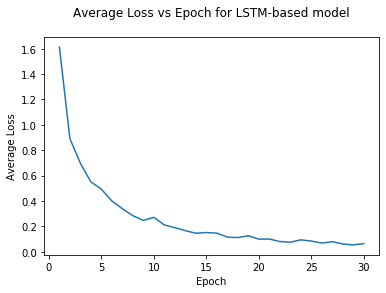

In [14]:
losslist = np.load("lstm_losslist.npy")
plt.plot(list(np.arange(1,len(losslist)+1)), losslist)
plt.title("Average Loss vs Epoch for LSTM-based model\n")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.savefig("plots/lstm_loss_plot.png")
plt.show()

In [38]:
def evaluate_quiet(net, X, Y, threshold=0.6):
    """Evaluates model performance on the input dataset using majority voting."""
    net.eval()
    N = len(Y)//200 # no of music samples in test set
    correct = 0
    for i in range(N):
        start = i*200
        with torch.no_grad():
            out = net.forward(X[start:start+200].to(device))
        preds = torch.argmax(out, axis=-1)
        labels = Y[start:start+200].to(device)
        if evaluate_sample(preds, labels, threshold):
            correct+=1

    return correct/N   

### Comparison of performance on the test set over epochs

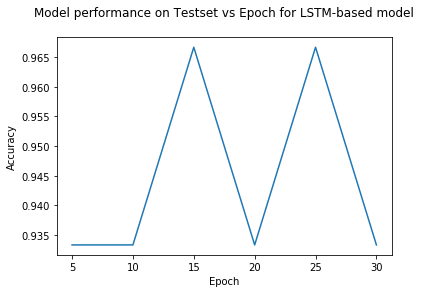

In [23]:
pfs = []
for i in list(range(5, 31, 5)):
    checkpoint = f"models/lstm_{i}_checkpoint.pth"
    model.load_state_dict(torch.load(checkpoint))
    pfs.append(evaluate_quiet(model, X_test, Y_test))
    
# Plot the data
plt.plot(np.arange(5,31,5), pfs)
plt.title("Model performance on Testset vs Epoch for LSTM-based model\n")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.savefig("plots/performance_over_epochs_plot.png")
plt.show()

In [40]:
checkpoint = f"models/lstm_25_checkpoint.pth"
net.load_state_dict(torch.load(checkpoint))
print(f"Accuracy on the Testset: {(100*evaluate_quiet(net, X_test, Y_test)):.2f}%")

Accuracy on the Testset: 96.67%


#### Redefine the deepSRGM model for Raga Classification using GRU

In [6]:
class Model(nn.Module):
    def __init__(self, input_length=5000, embedding_size=128, hidden_size=768,
                num_layers=1, num_classes=10, vocab_size=209, drop_prob=0.5):
      super(Model, self).__init__()
      self.num_layers = num_layers
      self.hidden_size = hidden_size
      self.fc1 = nn.Linear(hidden_size, 384)
      self.fc2 = nn.Linear(384, num_classes)
      # self.batchNorm1d = nn.BatchNorm1d(input_length)
      self.dropout = nn.Dropout(0.3)
      self.gru = nn.GRU(embedding_size, hidden_size, num_layers,
                          dropout=drop_prob, batch_first=True)
      self.embeddings = nn.Embedding(vocab_size, embedding_size)
      self.attention_layer = Attention(hidden_size, input_length)
      self.relu = nn.ReLU()

    def forward(self, x):
      batch_size = x.size(0)
      embeds = self.embeddings(x)
      out, _ = self.gru(embeds) #We don't need the hidden tensor
      # out = self.batchNorm1d(out)
      out = self.attention_layer(out)
     
      out = self.relu(self.fc1(out))
      out = self.dropout(out)
      out = self.fc2(out)

      return out

### Train new model for Raga Recognition

In [7]:
# create model instance

model = Model().to(device)

/opt/anaconda3/envs/pipenv/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


#### Train the model

In [24]:
# training the model
model.train()
losslist = []
for epoch in range(30):  # loop over the dataset multiple times
    running_loss = 0.0
    epoch_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 15 == 14:    # print every 15 mini-batches
            print(f'Epoch: {epoch+1} | Batches Done: {i+1}/450 | Loss: {(running_loss/15):.3f}')
            epoch_loss += running_loss
            running_loss = 0.0
    losslist.append(epoch_loss/450)
    print("="*50)
    print(f"EPOCH {epoch+1} OVERALL LOSS: {losslist[-1]:.3f}")
    print("="*50)
    if epoch % 5 == 4:
        path = f"models/gru_{epoch+1}_checkpoint.pth"
        print(f"Saving model weights at Epoch {epoch+1} ...")
        torch.save(model.state_dict(), path)

Epoch: 1 | Batches Done: 15/450 | Loss: 2.298
Epoch: 1 | Batches Done: 30/450 | Loss: 2.284
Epoch: 1 | Batches Done: 45/450 | Loss: 2.272
Epoch: 1 | Batches Done: 60/450 | Loss: 2.242
Epoch: 1 | Batches Done: 75/450 | Loss: 2.178
Epoch: 1 | Batches Done: 90/450 | Loss: 2.026
Epoch: 1 | Batches Done: 105/450 | Loss: 1.875
Epoch: 1 | Batches Done: 120/450 | Loss: 1.755
Epoch: 1 | Batches Done: 135/450 | Loss: 1.684
Epoch: 1 | Batches Done: 150/450 | Loss: 1.536
Epoch: 1 | Batches Done: 165/450 | Loss: 1.512
Epoch: 1 | Batches Done: 180/450 | Loss: 1.500
Epoch: 1 | Batches Done: 195/450 | Loss: 1.452
Epoch: 1 | Batches Done: 210/450 | Loss: 1.398
Epoch: 1 | Batches Done: 225/450 | Loss: 1.366
Epoch: 1 | Batches Done: 240/450 | Loss: 1.298
Epoch: 1 | Batches Done: 255/450 | Loss: 1.318
Epoch: 1 | Batches Done: 270/450 | Loss: 1.299
Epoch: 1 | Batches Done: 285/450 | Loss: 1.256
Epoch: 1 | Batches Done: 300/450 | Loss: 1.199
Epoch: 1 | Batches Done: 315/450 | Loss: 1.203
Epoch: 1 | Batches 

Epoch: 6 | Batches Done: 180/450 | Loss: 0.201
Epoch: 6 | Batches Done: 195/450 | Loss: 0.271
Epoch: 6 | Batches Done: 210/450 | Loss: 0.266
Epoch: 6 | Batches Done: 225/450 | Loss: 0.211
Epoch: 6 | Batches Done: 240/450 | Loss: 0.238
Epoch: 6 | Batches Done: 255/450 | Loss: 0.226
Epoch: 6 | Batches Done: 270/450 | Loss: 0.241
Epoch: 6 | Batches Done: 285/450 | Loss: 0.305
Epoch: 6 | Batches Done: 300/450 | Loss: 0.292
Epoch: 6 | Batches Done: 315/450 | Loss: 0.290
Epoch: 6 | Batches Done: 330/450 | Loss: 0.293
Epoch: 6 | Batches Done: 345/450 | Loss: 0.236
Epoch: 6 | Batches Done: 360/450 | Loss: 0.262
Epoch: 6 | Batches Done: 375/450 | Loss: 0.252
Epoch: 6 | Batches Done: 390/450 | Loss: 0.251
Epoch: 6 | Batches Done: 405/450 | Loss: 0.248
Epoch: 6 | Batches Done: 420/450 | Loss: 0.224
Epoch: 6 | Batches Done: 435/450 | Loss: 0.255
Epoch: 6 | Batches Done: 450/450 | Loss: 0.234
EPOCH 6 OVERALL LOSS: 0.251
Epoch: 7 | Batches Done: 15/450 | Loss: 0.239
Epoch: 7 | Batches Done: 30/450 |

Epoch: 11 | Batches Done: 330/450 | Loss: 0.101
Epoch: 11 | Batches Done: 345/450 | Loss: 0.135
Epoch: 11 | Batches Done: 360/450 | Loss: 0.142
Epoch: 11 | Batches Done: 375/450 | Loss: 0.139
Epoch: 11 | Batches Done: 390/450 | Loss: 0.120
Epoch: 11 | Batches Done: 405/450 | Loss: 0.123
Epoch: 11 | Batches Done: 420/450 | Loss: 0.093
Epoch: 11 | Batches Done: 435/450 | Loss: 0.095
Epoch: 11 | Batches Done: 450/450 | Loss: 0.095
EPOCH 11 OVERALL LOSS: 0.120
Epoch: 12 | Batches Done: 15/450 | Loss: 0.094
Epoch: 12 | Batches Done: 30/450 | Loss: 0.074
Epoch: 12 | Batches Done: 45/450 | Loss: 0.100
Epoch: 12 | Batches Done: 60/450 | Loss: 0.122
Epoch: 12 | Batches Done: 75/450 | Loss: 0.124
Epoch: 12 | Batches Done: 90/450 | Loss: 0.107
Epoch: 12 | Batches Done: 105/450 | Loss: 0.116
Epoch: 12 | Batches Done: 120/450 | Loss: 0.132
Epoch: 12 | Batches Done: 135/450 | Loss: 0.130
Epoch: 12 | Batches Done: 150/450 | Loss: 0.127
Epoch: 12 | Batches Done: 165/450 | Loss: 0.118
Epoch: 12 | Batch

Epoch: 16 | Batches Done: 435/450 | Loss: 0.074
Epoch: 16 | Batches Done: 450/450 | Loss: 0.086
EPOCH 16 OVERALL LOSS: 0.077
Epoch: 17 | Batches Done: 15/450 | Loss: 0.073
Epoch: 17 | Batches Done: 30/450 | Loss: 0.068
Epoch: 17 | Batches Done: 45/450 | Loss: 0.059
Epoch: 17 | Batches Done: 60/450 | Loss: 0.061
Epoch: 17 | Batches Done: 75/450 | Loss: 0.086
Epoch: 17 | Batches Done: 90/450 | Loss: 0.082
Epoch: 17 | Batches Done: 105/450 | Loss: 0.066
Epoch: 17 | Batches Done: 120/450 | Loss: 0.059
Epoch: 17 | Batches Done: 135/450 | Loss: 0.059
Epoch: 17 | Batches Done: 150/450 | Loss: 0.056
Epoch: 17 | Batches Done: 165/450 | Loss: 0.076
Epoch: 17 | Batches Done: 180/450 | Loss: 0.063
Epoch: 17 | Batches Done: 195/450 | Loss: 0.071
Epoch: 17 | Batches Done: 210/450 | Loss: 0.060
Epoch: 17 | Batches Done: 225/450 | Loss: 0.070
Epoch: 17 | Batches Done: 240/450 | Loss: 0.072
Epoch: 17 | Batches Done: 255/450 | Loss: 0.206
Epoch: 17 | Batches Done: 270/450 | Loss: 0.144
Epoch: 17 | Batch

Epoch: 22 | Batches Done: 60/450 | Loss: 0.043
Epoch: 22 | Batches Done: 75/450 | Loss: 0.049
Epoch: 22 | Batches Done: 90/450 | Loss: 0.034
Epoch: 22 | Batches Done: 105/450 | Loss: 0.052
Epoch: 22 | Batches Done: 120/450 | Loss: 0.063
Epoch: 22 | Batches Done: 135/450 | Loss: 0.037
Epoch: 22 | Batches Done: 150/450 | Loss: 0.049
Epoch: 22 | Batches Done: 165/450 | Loss: 0.036
Epoch: 22 | Batches Done: 180/450 | Loss: 0.055
Epoch: 22 | Batches Done: 195/450 | Loss: 0.041
Epoch: 22 | Batches Done: 210/450 | Loss: 0.061
Epoch: 22 | Batches Done: 225/450 | Loss: 0.040
Epoch: 22 | Batches Done: 240/450 | Loss: 0.029
Epoch: 22 | Batches Done: 255/450 | Loss: 0.047
Epoch: 22 | Batches Done: 270/450 | Loss: 0.064
Epoch: 22 | Batches Done: 285/450 | Loss: 0.043
Epoch: 22 | Batches Done: 300/450 | Loss: 0.030
Epoch: 22 | Batches Done: 315/450 | Loss: 0.054
Epoch: 22 | Batches Done: 330/450 | Loss: 0.017
Epoch: 22 | Batches Done: 345/450 | Loss: 0.044
Epoch: 22 | Batches Done: 360/450 | Loss: 0

Epoch: 27 | Batches Done: 165/450 | Loss: 0.045
Epoch: 27 | Batches Done: 180/450 | Loss: 0.034
Epoch: 27 | Batches Done: 195/450 | Loss: 0.024
Epoch: 27 | Batches Done: 210/450 | Loss: 0.036
Epoch: 27 | Batches Done: 225/450 | Loss: 0.023
Epoch: 27 | Batches Done: 240/450 | Loss: 0.015
Epoch: 27 | Batches Done: 255/450 | Loss: 0.036
Epoch: 27 | Batches Done: 270/450 | Loss: 0.031
Epoch: 27 | Batches Done: 285/450 | Loss: 0.050
Epoch: 27 | Batches Done: 300/450 | Loss: 0.023
Epoch: 27 | Batches Done: 315/450 | Loss: 0.046
Epoch: 27 | Batches Done: 330/450 | Loss: 0.065
Epoch: 27 | Batches Done: 345/450 | Loss: 0.025
Epoch: 27 | Batches Done: 360/450 | Loss: 0.032
Epoch: 27 | Batches Done: 375/450 | Loss: 0.077
Epoch: 27 | Batches Done: 390/450 | Loss: 0.111
Epoch: 27 | Batches Done: 405/450 | Loss: 0.143
Epoch: 27 | Batches Done: 420/450 | Loss: 0.077
Epoch: 27 | Batches Done: 435/450 | Loss: 0.042
Epoch: 27 | Batches Done: 450/450 | Loss: 0.068
EPOCH 27 OVERALL LOSS: 0.044
Epoch: 28 |

In [39]:
# save losslist for later comparison
np.save('gru_losslist.npy', losslist)

In [ ]:
# Reloading saved model
model = Model().to(device)
model.load_state_dict(torch.load("models/gru_30_checkpoint.pth"))

### Test model performance

In [15]:
# LSTM classified 8 and 18 as incorrect on the test set

In [16]:
evaluate(model, X_test, Y_test, threshold=0.6, verbose=True)

Sample 1/30 classified as CORRECT
Sample 2/30 classified as CORRECT
Sample 3/30 classified as CORRECT
Sample 4/30 classified as CORRECT
Sample 5/30 classified as CORRECT
Sample 6/30 classified as CORRECT
Sample 7/30 classified as CORRECT
Sample 8/30 classified as INCORRECT
Sample 9/30 classified as CORRECT
Sample 10/30 classified as CORRECT
Sample 11/30 classified as CORRECT
Sample 12/30 classified as CORRECT
Sample 13/30 classified as CORRECT
Sample 14/30 classified as CORRECT
Sample 15/30 classified as INCORRECT
Sample 16/30 classified as CORRECT
Sample 17/30 classified as CORRECT
Sample 18/30 classified as CORRECT
Sample 19/30 classified as CORRECT
Sample 20/30 classified as CORRECT
Sample 21/30 classified as CORRECT
Sample 22/30 classified as CORRECT
Sample 23/30 classified as CORRECT
Sample 24/30 classified as CORRECT
Sample 25/30 classified as CORRECT
Sample 26/30 classified as CORRECT
Sample 27/30 classified as CORRECT
Sample 28/30 classified as CORRECT
Sample 29/30 classified a

In [59]:
# Reloading saved model
model = Model().to(device)
model.load_state_dict(torch.load("gru_30_checkpoint.pth"))

<All keys matched successfully>

In [42]:
evaluate_naive(model, X_train, Y_train)

Accuracy on given data: 99.21%


In [43]:
evaluate_naive(model, X_test, Y_test)

Accuracy on given data: 83.68%


### Plot loss curve for comparison with LSTM

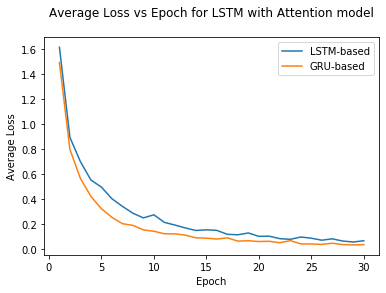

In [41]:
losslist_lstm = np.load('lstm_losslist.npy')
losslist_gru = np.load('gru_losslist.npy')

plt.plot(list(np.arange(1,len(losslist_lstm)+1)), losslist_lstm, label="LSTM-based")
plt.plot(list(np.arange(1,len(losslist_gru)+1)), losslist_gru, label="GRU-based")
plt.title("Average Loss vs Epoch for LSTM with Attention model\n")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.legend()
plt.savefig("plots/comparison_loss_plot.png")
plt.show()